In [36]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import PIL
import matplotlib.pyplot as plt

DEVICE = 'cuda:0'

trans = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root='./data', train=True, transform=trans, download=True)
test_set = datasets.MNIST(root='./data', train=False, transform=trans, download=True)

In [37]:

train_x = []; train_y = []
for x,y in train_set:
    x = x.view(1,-1)
    y = y.view(1,-1)
    train_x.append(x)
    train_y.append(y)

train_x = torch.cat(train_x, dim=0)
train_y = torch.cat(train_y, dim=0)


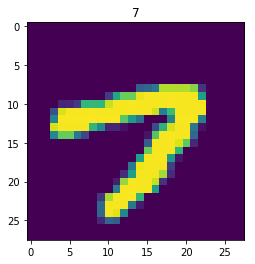

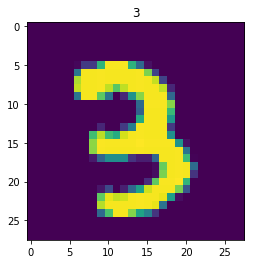

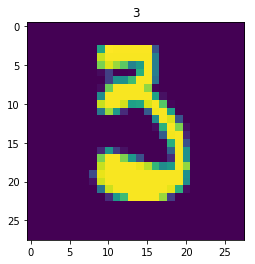

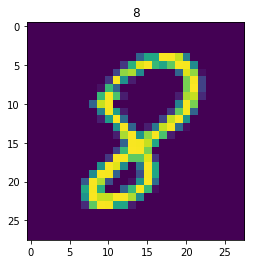

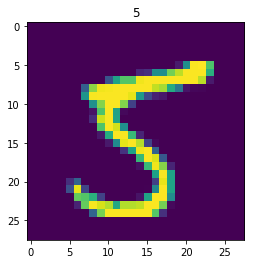

In [41]:
idx = torch.randint(len(train_x), size=(5,), dtype=torch.long)
for i in idx:
    plt.figure()
    plt.title(train_y[i].item())
    plt.imshow(train_x[i].numpy().reshape(28,28))
    

In [3]:

test_x = []; test_y = []
for x,y in test_set:
    x = x.view(1,-1)
    y = y.view(1,-1)
    test_x.append(x)
    test_y.append(y)

test_x = torch.cat(test_x, dim=0)
test_y = torch.cat(test_y, dim=0)
    

In [44]:
labels = []; s = 0
for lbl in range(10):
    label = train_y == lbl
    labels.append(label.view(-1))
    s += len(label.nonzero())
print('total train data: %d' % s)

total train data: 60000


In [45]:
class_data = []
for label in labels:
    data = train_x[label,:]
    class_data.append(data)

print('# classes: %d' % len(class_data))

# classes: 10


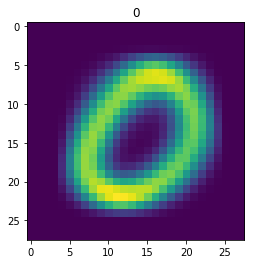

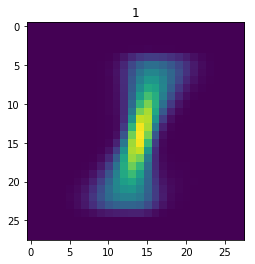

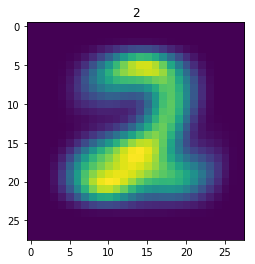

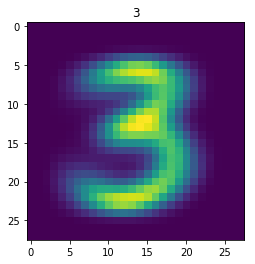

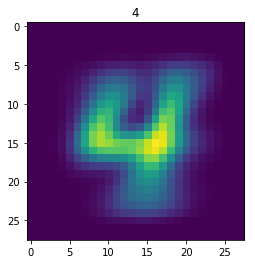

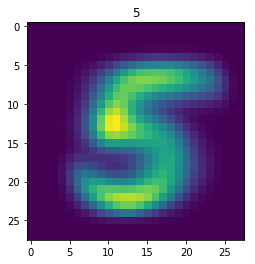

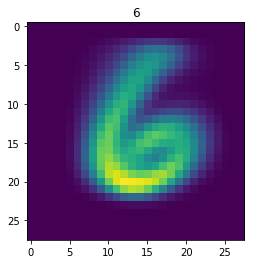

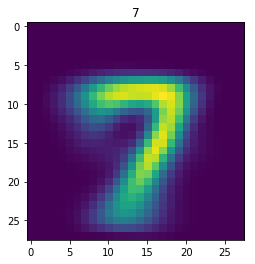

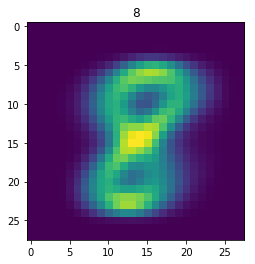

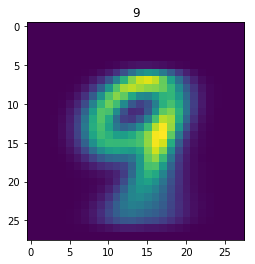

In [62]:
mus = []
for i,data in enumerate(class_data):
    mu = torch.mean(data, dim=0)
    mus.append(mu.unsqueeze(dim=0))
    plt.figure()
    plt.title(str(i))
    plt.imshow(mu.numpy().reshape(28,28))

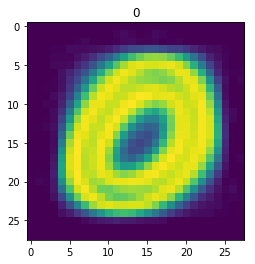

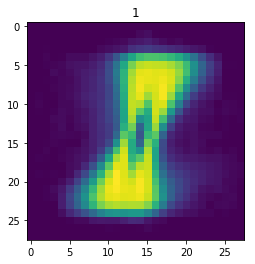

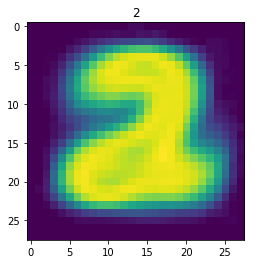

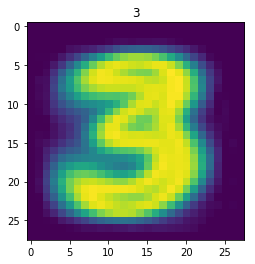

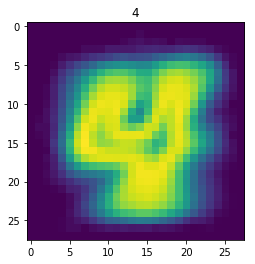

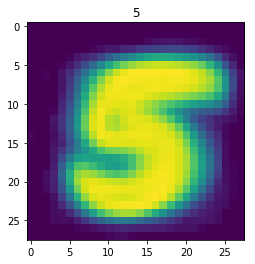

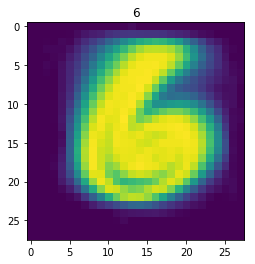

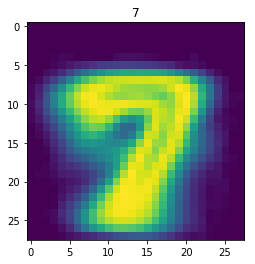

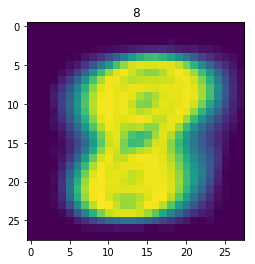

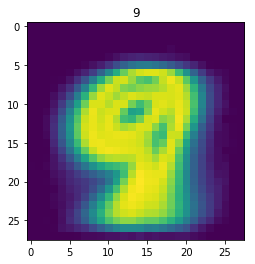

In [66]:
sigmas = []
for i,data in enumerate(class_data):
    std = torch.std(data, dim=0)
    sigmas.append(std.unsqueeze(dim=0))
    plt.figure()
    plt.title(str(i))
    plt.imshow(std.numpy().reshape(28,28))

In [67]:
def covariance_matrix(x):
    '''
    given x of shape [:, N], return cov matrix Sigma of shape [N, N]
    '''
    mu = torch.mean(x, dim=0, keepdim=True)
    return (x - mu).t() @ (x - mu) / (len(x) - 1.)


In [68]:
Ls, Vs = [], []
for data in class_data:
    Sigma = covariance_matrix(data)
    eig, V = torch.eig(Sigma, True)
    eig = eig[:,0]
    mask = eig > 1e-6
    eig = eig[mask]
    V = V[:,mask]
        
    Ls.append(torch.diag(eig**-0.5))
    Vs.append(V.t())


In [75]:
def predict(x, uncorrelate=True):
    '''
    given x of shape [:, -1], output prediction using Gaussian assumption
    '''
    error = []
    for mu,sigma,L,V in zip(mus, sigmas, Ls, Vs):
        w = x - mu
        if uncorrelate:
            w = L @ V @ w.t()
            w = w.t()
        else:
            w = w / torch.clamp(sigma, min=1e-10)
        error.append(torch.norm(w, dim=1, keepdim=True))
    error = torch.cat(error, dim=1)
    return error

In [76]:
error = predict(test_x, False)
correct = len(torch.nonzero(torch.argmin(error, dim=1) == test_y.view(-1)))
print('acc = %.2f%%' % (correct / len(test_x) * 100))

acc = 81.72%
